In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import sys
import os

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)

In [2]:
def distance(r1, r2):
    '''Euclidean distance between two points in 3D space.'''
    return math.sqrt(sum(c ** 2 for c in (c1 - c2 for c1, c2 in zip(r1, r2)))) 

def sphere_radius(volume):
    '''Radius of sphere with specified volume.'''
    return (volume * (3 / 4) / math.pi) ** (1 / 3)

In [3]:
path_nistats_results = os.path.join(
    path_root, 
    'data/main_fmri_study/derivatives/nistats/results')
path_clusters_perr = os.path.join(
    path_nistats_results,
    'clusters_perr_aggregated_manually_labeled.csv')

df = pd.read_csv(path_clusters_perr)
df = df[['Regions', 'Hemisphere', 'X', 'Y', 'Z', 
         'Peak Stat', 'Cluster Size (mm3)']]

# Split into separate DataFrames for each contrast
row_inc = (df['Regions'] == 'perr_inc_alpha_0_0001').idxmax()
row_dec = (df['Regions'] == 'perr_dec_alpha_0_0001').idxmax()
row_diff = (df['Regions'] == 'perr_rew_minus_pun_alpha_0_001').idxmax()
df_inc_dd = df[row_inc+1:row_dec].copy()
df_dec_dd = df[row_dec+1:row_diff].copy()

### Decreasing prediction error

In [4]:
ale_clusters_dec_data = [
    ['Dorsomedial cingulate cortex', 'R', 2, 24, 36, 0.051, 12712],
]

ale_clusters_dec_dicts = [
    {k: v for k, v in zip(df_dec_dd.columns, cluster_data)} 
    for cluster_data in ale_clusters_dec_data]

# Metaanalytic decreasing PE ROIs
df_dec_meta = pd.DataFrame(ale_clusters_dec_dicts)
df_dec_meta['origin'] = 'meta-analysis'

# Data-driven decreasing PE ROIs
df_dec_dd = df_dec_dd.loc[
    (df_dec_dd['Peak Stat'] > 6) & (df_dec_dd['Regions'].notna())]
df_dec_dd['origin'] = 'data-driven'

# Aggregated ROIs
df_dec = pd.concat([df_dec_dd, df_dec_meta])
df_dec.reset_index(inplace=True, drop=True)
df_dec['netName'] = 'perr_dec'

### Increasing prediction error

In [5]:
ale_clusters_inc_data = [
    ['Ventral striatum', 'L', -12, 8, -4, 0.052, 4880],
    ['Ventral striatum', 'R', 8, 8, -2, 0.038, 2880],
]

ale_clusters_inc_dicts = [
    {k: v for k, v in zip(df_inc_dd.columns, cluster_data)} 
    for cluster_data in ale_clusters_inc_data]

# Metaanalytic increasing PE ROIs
df_inc_meta = pd.DataFrame(ale_clusters_inc_dicts)
df_inc_meta['origin'] = 'meta-analysis'

# Data-driven increasing PE ROIs
df_inc_dd = df_inc_dd.loc[
    (df_inc_dd['Peak Stat'] > 6.49) & (df_inc_dd['Regions'].notna())]
df_inc_dd['origin'] = 'data-driven'

# Aggregated ROIs
df_inc = pd.concat([df_inc_dd, df_inc_meta])
df_inc.reset_index(inplace=True, drop=True)
df_inc['netName'] = 'perr_inc'

In [6]:
df_aggregated = pd.concat([df_inc, df_dec])
df_aggregated.reset_index(inplace=True, drop=True)
df_aggregated['approxRadius'] = df_aggregated['Cluster Size (mm3)'].map(
    sphere_radius)
df_aggregated

,Regions,Hemisphere,X,Y,Z,Peak Stat,Cluster Size (mm3),origin,netName,approxRadius
0,Putamen,L,-30.0,-12.0,2.5,7.195100,6961.0,data-driven,perr_inc,11.844798
1,Lateral Orbitofrontal Cortex,L,-39.0,33.0,-11.5,6.998819,3969.0,data-driven,perr_inc,9.821945
2,Ventromedial Prefrontal Cortex,L,-3.0,48.0,-1.0,6.956164,26460.0,data-driven,perr_inc,18.485608
3,Superior Temporal Gyrus,L,-48.0,-36.0,2.5,6.565050,5103.0,data-driven,perr_inc,10.680190
4,"Putamen, Ventral Striatum",R,30.0,-9.0,6.0,6.499816,6363.0,data-driven,perr_inc,11.495409
5,Ventral striatum,L,-12.0,8.0,-4.0,0.052000,4880.0,meta-analysis,perr_inc,10.522293
6,Ventral striatum,R,8.0,8.0,-2.0,0.038000,2880.0,meta-analysis,perr_inc,8.826082
7,Supplementary Motor Area,L,-6.0,18.0,44.5,7.856539,9513.0,data-driven,perr_dec,13.144466
8,Supplementary Motor Area,R,15.0,9.0,69.0,6.794687,2016.0,data-driven,perr_dec,7.836714
9,Anterior Insula,L,-33.0,24.0,6.0,6.504029,1795.0,data-driven,perr_dec,7.539200


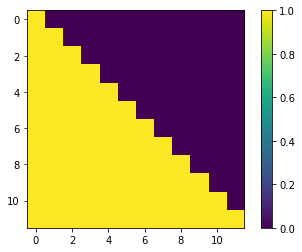

In [18]:
n_rois = len(df_aggregated)

distance_matrix = np.zeros((n_rois, n_rois))

for i in range(n_rois):
    for j in range(i, n_rois):
        distance_matrix[i, j] = distance(
            df_aggregated.loc[i, ['X', 'Y', 'Z']],
            df_aggregated.loc[j, ['X', 'Y', 'Z']]
        )
        
plt.imshow(distance_matrix < 10)
plt.colorbar()